In [67]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [68]:
years = range(2018, 2024)
dfs = []

base_path = '../../data/clean/complex/final/player_data_{}.csv'  # Update with actual path
for year in years:
    df = pd.read_csv(base_path.format(year))
    df['Year'] = year
    df['Score'] = 101 - df['Rank']  # convert rank to score
    dfs.append(df)

train_df = pd.concat(dfs, ignore_index=True)

train_df.head()


,Player,adr,assists__per__round,b_adr,b_assists__per__round,b_damage__per__round,b_deaths__per__round,b_dpr,b_grenade_dmg__per__round,b_headshot_%,...,vs_top20,vs_top30,vs_top5,MVPs,EVPs,Rank,Year,Score,b_rating_1.0,m_rating_1.0
0,s1mple,87.2,0.10,87.4,0.11,87.4,0.59,0.59,2.7,41.7,...,1.34,1.34,1.35,6,4,1,2018,100,NaN,NaN
1,device,81.4,0.12,80.8,0.12,80.8,0.59,0.59,5.1,32.3,...,1.24,1.24,1.23,7,1,2,2018,99,NaN,NaN
2,NiKo,84.8,0.13,86.6,0.13,86.6,0.63,0.63,3.6,48.3,...,1.20,1.21,1.21,2,7,3,2018,98,NaN,NaN
3,electronic,84.5,0.14,82.2,0.13,82.2,0.63,0.63,4.6,48.7,...,1.16,1.18,1.20,0,7,4,2018,97,NaN,NaN
4,dupreeh,79.8,0.14,78.7,0.14,78.7,0.63,0.63,3.2,49.7,...,1.17,1.16,1.17,1,8,5,2018,96,NaN,NaN


In [69]:
# Load 2024 test data
test_df = pd.read_csv('../../data/clean/complex/final/player_data_2024.csv')
test_df['Year'] = 2024
test_df['Score'] = 0  # Placeholder
test_df.head()


,Player,adr,assists__per__round,b_adr,b_assists__per__round,b_damage__per__round,b_deaths__per__round,b_dpr,b_grenade_dmg__per__round,b_headshot_%,...,total_kills,vs_top10,vs_top20,vs_top30,vs_top5,MVPs,EVPs,Rank,Year,Score
0,donk,96.8,0.21,94.3,0.20,94.3,0.68,0.68,3.3,58.4,...,3032.0,1.28,1.32,1.34,1.36,5,3,1,2024,0
1,m0NESY,82.7,0.14,82.8,0.14,82.8,0.59,0.59,3.0,42.1,...,3174.0,1.25,1.28,1.28,1.27,3,5,2,2024,0
2,ZywOo,88.9,0.18,87.6,0.17,87.6,0.59,0.59,4.1,44.0,...,2753.0,1.28,1.33,1.35,1.34,2,7,3,2024,0
3,NiKo,82.3,0.21,81.4,0.21,81.4,0.64,0.64,6.0,54.9,...,2927.0,1.16,1.17,1.17,1.16,0,6,4,2024,0
4,jL,78.5,0.21,78.3,0.20,78.3,0.65,0.65,4.6,54.7,...,2617.0,1.10,1.10,1.12,1.13,2,4,5,2024,0


In [70]:
# Cell 3 - Rating normalization + preprocessing
def unify_rating_columns(df):
    if 'rating_2.1' in df.columns:
        df['rating'] = df['rating_2.1']
    elif 'rating_2.0' in df.columns:
        df['rating'] = df['rating_2.0']
    elif 'rating_1.0' in df.columns:
        df['rating'] = df['rating_1.0']
    else:
        df['rating'] = np.nan
    for col in ['rating_2.1', 'rating_2.0', 'rating_1.0']:
        if col in df.columns:
            df.drop(columns=col, inplace=True)
    return df

train_df = unify_rating_columns(train_df)
test_df = unify_rating_columns(test_df)

id_cols = ['Player', 'HLTV_ID', 'Rank', 'Year']
feature_cols = [col for col in train_df.columns if col not in id_cols + ['Score']]
shared_cols = list(set(feature_cols) & set(test_df.columns))

train_df[shared_cols] = train_df[shared_cols].replace(-1.0, np.nan).fillna(train_df[shared_cols].mean())
test_df[shared_cols] = test_df[shared_cols].replace(-1.0, np.nan).fillna(train_df[shared_cols].mean())

scaler = StandardScaler()
X_train = scaler.fit_transform(train_df[shared_cols])
y_train = train_df['Score'].values
X_test = scaler.transform(test_df[shared_cols])

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)


In [71]:
# Cell 4 - Model architecture
class DeepRankNet(nn.Module):
    def __init__(self, input_dim):
        super(DeepRankNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)



⏱️ Fold 1
Epoch 000 | Train: 7917.7031 | Val: 7744.7866
Epoch 010 | Train: 7786.1118 | Val: 7682.6445
Epoch 020 | Train: 7528.0962 | Val: 7454.8491
Epoch 030 | Train: 6953.6978 | Val: 6915.3213
Epoch 040 | Train: 5868.8257 | Val: 6000.3052
Epoch 050 | Train: 4171.7397 | Val: 4627.7256
Epoch 060 | Train: 2069.0820 | Val: 2731.5449
Epoch 070 | Train: 432.8617 | Val: 942.4212
Epoch 080 | Train: 198.3354 | Val: 321.7051
Epoch 090 | Train: 196.9256 | Val: 247.0774
Epoch 100 | Train: 162.8194 | Val: 340.2317
Epoch 110 | Train: 158.2160 | Val: 273.7286
Epoch 120 | Train: 116.4573 | Val: 175.0918
Epoch 130 | Train: 111.1751 | Val: 106.3617
Epoch 140 | Train: 108.3535 | Val: 117.2584
Epoch 150 | Train: 127.9311 | Val: 91.4423
Epoch 160 | Train: 102.2233 | Val: 133.0156
Epoch 170 | Train: 105.1319 | Val: 112.6746
Epoch 180 | Train: 120.2555 | Val: 96.1064
Epoch 190 | Train: 146.6278 | Val: 87.0859
Epoch 200 | Train: 116.4762 | Val: 77.9531
Epoch 210 | Train: 105.5430 | Val: 79.7961
Epoch 220 | 

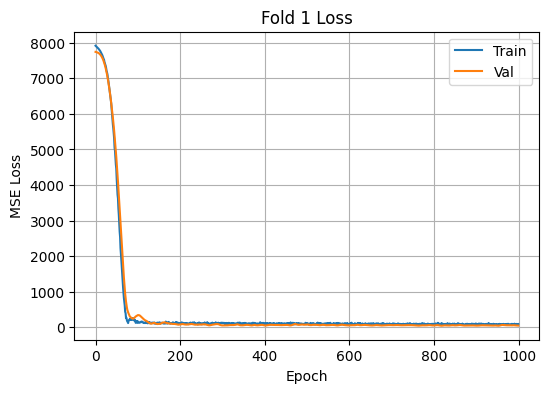


⏱️ Fold 2
Epoch 000 | Train: 7814.8828 | Val: 8001.6318
Epoch 010 | Train: 7726.9956 | Val: 7956.6528
Epoch 020 | Train: 7538.3540 | Val: 7778.2822
Epoch 030 | Train: 7112.4946 | Val: 7319.9888
Epoch 040 | Train: 6199.5781 | Val: 6449.6562
Epoch 050 | Train: 4651.5068 | Val: 5010.4062
Epoch 060 | Train: 2593.5981 | Val: 3043.8220
Epoch 070 | Train: 781.9802 | Val: 1020.6138
Epoch 080 | Train: 174.3565 | Val: 167.8086
Epoch 090 | Train: 229.8609 | Val: 172.5893
Epoch 100 | Train: 167.5385 | Val: 195.1816
Epoch 110 | Train: 152.8669 | Val: 269.2078
Epoch 120 | Train: 151.2446 | Val: 141.3191
Epoch 130 | Train: 142.3132 | Val: 95.4573
Epoch 140 | Train: 139.0042 | Val: 70.9327
Epoch 150 | Train: 143.7975 | Val: 46.4805
Epoch 160 | Train: 106.1620 | Val: 101.7331
Epoch 170 | Train: 109.2351 | Val: 94.6782
Epoch 180 | Train: 152.2153 | Val: 96.1556
Epoch 190 | Train: 144.8473 | Val: 51.8745
Epoch 200 | Train: 127.8789 | Val: 63.3049
Epoch 210 | Train: 121.2217 | Val: 85.5902
Epoch 220 | Tr

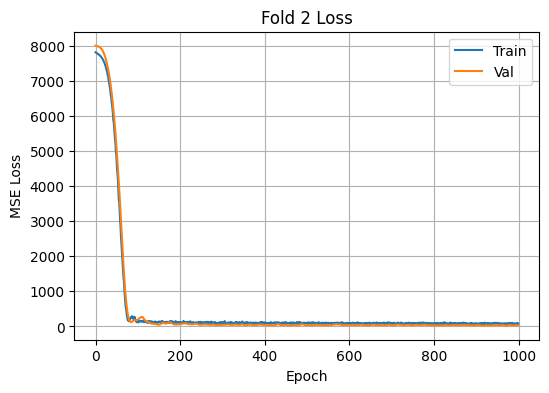


⏱️ Fold 3
Epoch 000 | Train: 7759.0381 | Val: 8232.4668
Epoch 010 | Train: 7660.8525 | Val: 8180.9971
Epoch 020 | Train: 7451.1953 | Val: 7996.4609
Epoch 030 | Train: 6964.9331 | Val: 7528.6431
Epoch 040 | Train: 5976.3350 | Val: 6618.3970
Epoch 050 | Train: 4440.1812 | Val: 5085.7803
Epoch 060 | Train: 2361.5730 | Val: 3084.4780
Epoch 070 | Train: 608.6420 | Val: 1192.8761
Epoch 080 | Train: 137.9361 | Val: 427.7448
Epoch 090 | Train: 200.1091 | Val: 307.3471
Epoch 100 | Train: 132.6373 | Val: 408.1154
Epoch 110 | Train: 140.7587 | Val: 399.5239
Epoch 120 | Train: 145.8896 | Val: 324.2380
Epoch 130 | Train: 125.5916 | Val: 245.5382
Epoch 140 | Train: 91.4157 | Val: 234.8960
Epoch 150 | Train: 111.6849 | Val: 223.4144
Epoch 160 | Train: 129.7620 | Val: 217.3463
Epoch 170 | Train: 132.1773 | Val: 181.8246
Epoch 180 | Train: 93.4852 | Val: 198.8711
Epoch 190 | Train: 118.4697 | Val: 175.5236
Epoch 200 | Train: 147.1527 | Val: 166.6346
Epoch 210 | Train: 166.8418 | Val: 167.1767
Epoch 22

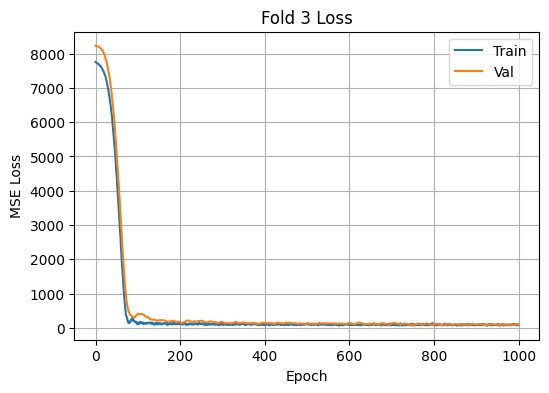


⏱️ Fold 4
Epoch 000 | Train: 7940.4092 | Val: 7731.1538
Epoch 010 | Train: 7836.0337 | Val: 7687.4805
Epoch 020 | Train: 7692.7627 | Val: 7567.7021
Epoch 030 | Train: 7358.6606 | Val: 7309.0186
Epoch 040 | Train: 6708.4131 | Val: 6810.4404
Epoch 050 | Train: 5654.7935 | Val: 5904.3623
Epoch 060 | Train: 4085.2727 | Val: 4599.4819
Epoch 070 | Train: 2227.6519 | Val: 2691.4480
Epoch 080 | Train: 601.1288 | Val: 1039.3199
Epoch 090 | Train: 154.4158 | Val: 337.3612
Epoch 100 | Train: 220.7849 | Val: 191.4505
Epoch 110 | Train: 130.1619 | Val: 261.3319
Epoch 120 | Train: 139.4382 | Val: 288.2266
Epoch 130 | Train: 123.1511 | Val: 215.6426
Epoch 140 | Train: 139.6088 | Val: 177.9568
Epoch 150 | Train: 104.8294 | Val: 136.3429
Epoch 160 | Train: 130.8774 | Val: 148.1111
Epoch 170 | Train: 135.9510 | Val: 145.2859
Epoch 180 | Train: 145.1275 | Val: 121.2037
Epoch 190 | Train: 115.9489 | Val: 91.5277
Epoch 200 | Train: 154.6203 | Val: 80.9553
Epoch 210 | Train: 114.8803 | Val: 109.1550
Epoch 

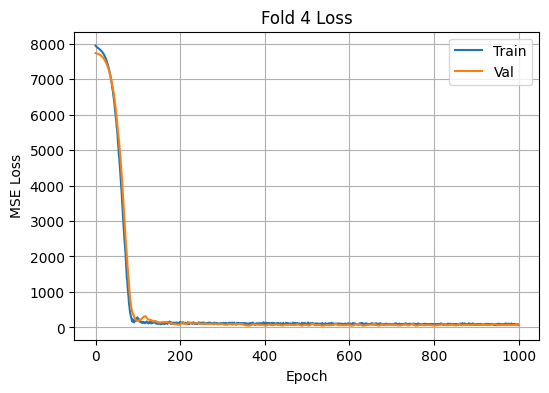


⏱️ Fold 5
Epoch 000 | Train: 7940.7603 | Val: 7615.4976
Epoch 010 | Train: 7817.9087 | Val: 7550.4062
Epoch 020 | Train: 7495.1382 | Val: 7281.7075
Epoch 030 | Train: 6732.7603 | Val: 6625.7007
Epoch 040 | Train: 5409.2661 | Val: 5389.9961
Epoch 050 | Train: 3305.2793 | Val: 3616.3801
Epoch 060 | Train: 1142.2413 | Val: 1654.1705
Epoch 070 | Train: 153.0505 | Val: 497.4851
Epoch 080 | Train: 335.1766 | Val: 253.6894
Epoch 090 | Train: 146.7531 | Val: 242.5172
Epoch 100 | Train: 157.6171 | Val: 312.3155
Epoch 110 | Train: 119.6254 | Val: 224.4820
Epoch 120 | Train: 148.2129 | Val: 97.0344
Epoch 130 | Train: 93.1411 | Val: 96.0889
Epoch 140 | Train: 127.4497 | Val: 112.3319
Epoch 150 | Train: 109.7301 | Val: 102.3966
Epoch 160 | Train: 98.6535 | Val: 77.9641
Epoch 170 | Train: 122.7033 | Val: 60.2965
Epoch 180 | Train: 122.5378 | Val: 63.1874
Epoch 190 | Train: 119.9999 | Val: 75.4955
Epoch 200 | Train: 112.5228 | Val: 54.5524
Epoch 210 | Train: 96.4924 | Val: 53.9706
Epoch 220 | Train:

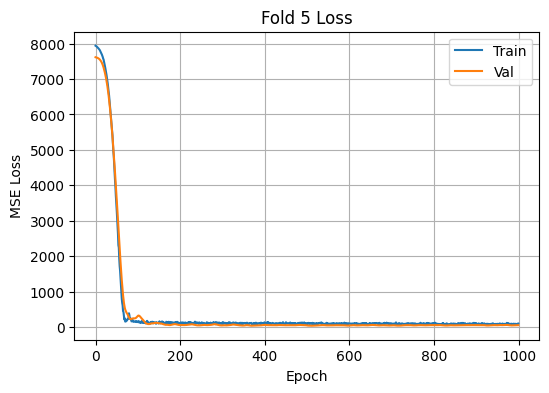


📉 Average CV Loss: 62.5535


In [72]:
# Cell 5 - Cross-validation training and evaluation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_tensor)):
    print(f"\n⏱️ Fold {fold+1}")

    model = DeepRankNet(X_train.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    criterion = nn.MSELoss()

    X_tr = X_train_tensor[train_idx].to(device)
    y_tr = y_train_tensor[train_idx].to(device)
    X_val = X_train_tensor[val_idx].to(device)
    y_val = y_train_tensor[val_idx].to(device)

    train_losses, val_losses = [], []

    for epoch in range(1000):
        model.train()
        optimizer.zero_grad()
        preds = model(X_tr)
        loss = criterion(preds, y_tr)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_preds = model(X_val)
            val_loss = criterion(val_preds, y_val)

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        if epoch % 10 == 0:
            print(f"Epoch {epoch:03d} | Train: {loss.item():.4f} | Val: {val_loss.item():.4f}")

    cv_scores.append(val_losses[-1])

    # Plot loss curves
    plt.figure(figsize=(6,4))
    plt.plot(train_losses, label="Train")
    plt.plot(val_losses, label="Val")
    plt.title(f"Fold {fold+1} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

print(f"\n📉 Average CV Loss: {np.mean(cv_scores):.4f}")


In [73]:
# Cell 6 - Final training on full dataset
model = DeepRankNet(X_train.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.MSELoss()

epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    preds = model(X_train_tensor.to(device))
    loss = criterion(preds, y_train_tensor.to(device))
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Final Training Epoch {epoch:03d} | Loss: {loss.item():.4f}")


Final Training Epoch 000 | Loss: 7848.8706
Final Training Epoch 010 | Loss: 7725.7427
Final Training Epoch 020 | Loss: 7472.8325
Final Training Epoch 030 | Loss: 6903.0762
Final Training Epoch 040 | Loss: 5856.4619
Final Training Epoch 050 | Loss: 4246.7197
Final Training Epoch 060 | Loss: 2256.1157
Final Training Epoch 070 | Loss: 595.1909
Final Training Epoch 080 | Loss: 165.0237
Final Training Epoch 090 | Loss: 190.0118
Final Training Epoch 100 | Loss: 129.7303
Final Training Epoch 110 | Loss: 158.3606
Final Training Epoch 120 | Loss: 150.9088
Final Training Epoch 130 | Loss: 114.1650
Final Training Epoch 140 | Loss: 123.8541
Final Training Epoch 150 | Loss: 130.6586
Final Training Epoch 160 | Loss: 138.8706
Final Training Epoch 170 | Loss: 137.0212
Final Training Epoch 180 | Loss: 122.4886
Final Training Epoch 190 | Loss: 92.0217
Final Training Epoch 200 | Loss: 109.7533
Final Training Epoch 210 | Loss: 90.4620
Final Training Epoch 220 | Loss: 121.4258
Final Training Epoch 230 | Lo

In [74]:
# Cell 7 - Predict and rank 2024 players
model.eval()
with torch.no_grad():
    preds_2024 = model(X_test_tensor.to(device)).cpu().numpy()

test_df['PredictedScore'] = preds_2024
top_20_2024 = test_df.sort_values(by='PredictedScore', ascending=False).head(20)
top_20_2024.reset_index(inplace=True)

print("\n🏆 Top 20 Predicted Players for 2024:")
print(top_20_2024[['Player', 'PredictedScore']])



🏆 Top 20 Predicted Players for 2024:
       Player  PredictedScore
0        donk      101.292572
1      m0NESY       98.932068
2       ZywOo       97.937263
3    XANTARES       92.478844
4        NiKo       92.210869
5      frozen       89.310532
6       EliGE       88.022163
7       broky       87.753021
8     xertioN       86.476990
9       sh1ro       86.006233
10     flameZ       85.286972
11       ropz       84.858955
12         jL       84.697830
13  w0nderful       82.928429
14      Spinx       82.721680
15   KSCERATO       82.295914
16      NertZ       81.773804
17        b1t       80.502930
18    Brollan       79.388206
19    malbsMd       79.040237


In [75]:
# Load actual HLTV 2024 rankings
actual_df = pd.read_csv('../../rankings/ranking_2024.csv')  # Update path

# Normalize nicknames in both DataFrames (for easier comparison)
def normalize(name):
    return name.strip().lower().replace("⁠", "").replace("’", "'").replace("`", "'")

actual_df['Nickname'] = actual_df['Nickname'].apply(normalize)
top_20_2024['Player'] = top_20_2024['Player'].apply(normalize)

# Map: nickname -> actual rank
actual_ranks = {row['Nickname']: row['Rank'] for _, row in actual_df.iterrows()}

# Evaluation function
def score_ranking(pred_df, actual_rank_dict):
    score = 0
    graded = []

    for pred_rank, row in enumerate(pred_df['Player'].values, 1):
        actual_rank = actual_rank_dict.get(row)

        if actual_rank:
            diff = abs(actual_rank - pred_rank)
            if diff == 0:
                pts = 5
            elif diff == 1:
                pts = 4
            elif diff == 2:
                pts = 3
            elif diff == 3:
                pts = 2
            elif diff <= 5:
                pts = 1
            else:
                pts = 0
        else:
            pts = 0

        graded.append((pred_rank, row, actual_rank, pts))
        score += pts

    return score, graded


In [76]:
# Run scoring
total_score, breakdown = score_ranking(top_20_2024, actual_ranks)

# Display summary
print(f"🏆 Total Ranking Score: {total_score}/100\n")
print("🔍 Breakdown:")
for pred_rank, nickname, actual_rank, pts in breakdown:
    print(f"Predicted #{pred_rank:>2}: {nickname:<15} | Actual: {actual_rank if actual_rank else 'N/A':<2} | +{pts} pts")

🏆 Total Ranking Score: 36/100

🔍 Breakdown:
Predicted # 1: donk            | Actual: 1  | +5 pts
Predicted # 2: m0nesy          | Actual: 2  | +5 pts
Predicted # 3: zywoo           | Actual: 3  | +5 pts
Predicted # 4: xantares        | Actual: 15 | +0 pts
Predicted # 5: niko            | Actual: 4  | +4 pts
Predicted # 6: frozen          | Actual: 10 | +1 pts
Predicted # 7: elige           | Actual: 19 | +0 pts
Predicted # 8: broky           | Actual: 8  | +5 pts
Predicted # 9: xertion         | Actual: 14 | +1 pts
Predicted #10: sh1ro           | Actual: 6  | +1 pts
Predicted #11: flamez          | Actual: 7  | +1 pts
Predicted #12: ropz            | Actual: 18 | +0 pts
Predicted #13: jl              | Actual: 5  | +0 pts
Predicted #14: w0nderful       | Actual: 11 | +2 pts
Predicted #15: spinx           | Actual: 13 | +3 pts
Predicted #16: kscerato        | Actual: 24 | +0 pts
Predicted #17: nertz           | Actual: 21 | +1 pts
Predicted #18: b1t             | Actual: 9  | +0 pts
Pr

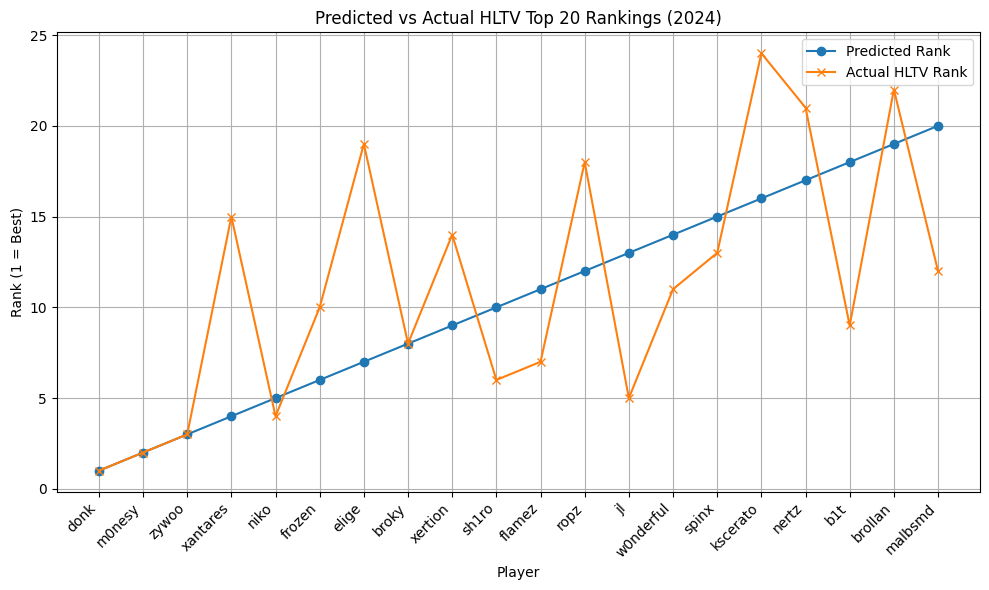

In [77]:
import matplotlib.pyplot as plt

# Normalize nicknames again for matching
def normalize(name):
    return name.strip().lower().replace("⁠", "").replace("’", "'").replace("`", "'")

actual_df['Nickname'] = actual_df['Nickname'].apply(normalize)
top_20_2024['Player'] = top_20_2024['Player'].apply(normalize)

# Create matching dict
actual_rank_map = {normalize(row['Nickname']): row['Rank'] for _, row in actual_df.iterrows()}

# Prepare bar chart
predicted_names = top_20_2024['Player'].tolist()
predicted_scores = list(range(1, 21))  # predicted rank = 1 to 20
actual_ranks = [actual_rank_map.get(name, None) for name in predicted_names]

plt.figure(figsize=(10,6))
plt.plot(predicted_names, predicted_scores, marker='o', label='Predicted Rank')
plt.plot(predicted_names, actual_ranks, marker='x', label='Actual HLTV Rank')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Player")
plt.ylabel("Rank (1 = Best)")
plt.title("Predicted vs Actual HLTV Top 20 Rankings (2024)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("ranking_eval.png")
plt.show()
